In [2]:
print("hello world")

hello world


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

res_threshold = 0.9
overlap_threshold = 0.01

CAMERA_WIDTH = 1024
CAMERA_HEIGHT = 768
BIRD_WIDTH = 550
BIRD_HEIGHT = 350

HSV_BLACK_MIN = np.array([0, 0, 0])
HSV_BLACK_MAX = np.array([179, 70, 70])
HSV_RED_MIN = np.array([165, 30, 30])
HSV_RED_MAX = np.array([180, 255, 255])
HSV_ORANGE_MIN = np.array([0, 30, 30])
HSV_ORANGE_MAX = np.array([15, 255, 255])
HSV_GREEN_MIN = np.array([70, 20, 20])
HSV_GREEN_MAX = np.array([90, 200, 200])



RES_THRESHOLD_BLACK = 0.8
RES_THRESHOLD_RED = 0.5

BINARY_THRESHOLD_BLACK = 50
BINARY_THRESHOLD_RED = 55

OVERLAP_THRESHOLD = 0.0001

CAMERA_CORNERS = [[0, 0], [CAMERA_WIDTH, 0], [CAMERA_WIDTH, CAMERA_HEIGHT], [0, CAMERA_HEIGHT]]
BIRD_CORNERS = [[0, 0], [BIRD_WIDTH, 0], [BIRD_WIDTH, BIRD_HEIGHT], [0, BIRD_HEIGHT]]


#color filters
HSV_RED_MIN = np.array([165, 30, 30])
HSV_RED_MAX = np.array([180, 255, 255])
HSV_ORANGE_MIN = np.array([0, 30, 30])
HSV_ORANGE_MAX = np.array([15, 255, 255])

HSV_GREEN_MIN = np.array([65, 40, 40])
HSV_GREEN_MAX = np.array([85, 255, 255])

HSV_BLUE_MIN = np.array([85, 100, 100])
HSV_BLUE_MAX = np.array([110, 255, 255])

TOLERANCE_HSV = np.array([8, 100, 100])

#change those values with the camera 
RED_BGR = np.array([115, 95, 194], dtype = np.uint8)
BLUE_BGR = np.array([134, 73, 12], dtype= np.uint8)
GREEN_BGR = np.array([29, 72, 56], dtype = np.uint8)
ORANGE_BGR = np.array([134, 73, 12], dtype = np.uint8)

#camera and map parameters
CAMERA_WIDTH = 1024
CAMERA_HEIGHT = 768
BIRD_WIDTH = 330
BIRD_HEIGHT = 246
CAMERA_CORNERS = [[0, 0], [CAMERA_WIDTH, 0], [CAMERA_WIDTH, CAMERA_HEIGHT], [0, CAMERA_HEIGHT]]
BIRD_CORNERS = [[0, 0], [BIRD_WIDTH, 0], [BIRD_WIDTH, BIRD_HEIGHT], [0, BIRD_HEIGHT]]
MAP_WIDTH = 1200
MAP_HEIGHT = 900
MAP_CORNERS = np.array([[0, 0], [MAP_WIDTH, 0], [MAP_WIDTH, MAP_HEIGHT], [0, MAP_HEIGHT]], dtype=np.float32)

#matching thresholds
RES_THRESHOLD_BLACK = 0.82
RES_THRESHOLD_RED = 0.4
RES_THRESHOLD_GREEN = 0.6

#binary thresholds
BINARY_THRESHOLD_BLACK = 42
BINARY_THRESHOLD_RED = 27
BINARY_THRESHOLD_GREEN = 50
BINARY_THRESHOLD_BLUE = 27

OVERLAP_THRESHOLD = 0
THYMIO_WIDTH = 17
TEMP_CENTER_Y = 53
TEMP_CENTER_X = 69

OBSTACLE_MAP_VALUE = -1
BACKGROUND_MAP_VALUE = 0

#templates
template_cross = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/template_cross_dll.jpg')
template_l_thymio = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/template_thymio_T.jpg')
template_goal = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/template_goal_binary.jpg')

method = eval('cv2.TM_CCORR_NORMED')

In [4]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")


#--------------------------------------------------------------------------------------------------------------------------------------------------
def order_points(pts):
	# sort the points based on their x-coordinates
	xSorted = pts[np.argsort(pts[:, 0]), :]
	# grab the left-most and right-most points from the sorted
	# x-roodinate points
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
	# now, sort the left-most coordinates according to their
	# y-coordinates so we can grab the top-left and bottom-left
	# points, respectively
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
	# now that we have the top-left coordinate, use it as an
	# anchor to calculate the Euclidean distance between the
	# top-left and right-most points; by the Pythagorean
	# theorem, the point with the largest distance will be
	# our bottom-right point
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
	# return the coordinates in top-left, top-right,
	# bottom-right, and bottom-left order
	return np.array([tl, tr, br, bl], dtype="float32")


#--------------------------------------------------------------------------------------------------------
def filter_to_hsv(image):
	filtered_img = cv2.GaussianBlur(image,(5,5),1)
    
    # Convert BGR to HSV
	hsv_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2HSV)
	return hsv_img


#----------------------------------------------------------------------------------------------------------
def find_l_thymio(bw, template):
	"""find coordinates of thymio
	arguments :	
		bw : image in the hsv color space;	
		template : image that has been filtered and is in the binary color space;	
		method : cross-correlation method for template matching
	"""
	is_found = False
	c, w, h  = template.shape[::-1]
	
	template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
	threshold = BINARY_THRESHOLD_RED
	ret2, template_binary = cv2.threshold(template, threshold, 255, cv2.THRESH_BINARY)

	#find location of thymio
	contours, hierarchy  = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
	if len(contours) != 0:
		contours = sorted(contours, key = cv2.contourArea, reverse = True)
		contour = contours[0]
	
		M = cv2.moments(contour)
		cX = int(M["m10"]/M["m00"])
		cY = int(M["m01"]/M["m00"])
		is_found = True
	else:
		cX = 0
		cY = 0
		is_found = False
	
	position = (cX, cY)	
	
	return is_found, position

#----------------------------------------------------------------------------------------------------------------------
def find_thymio_angle(image, template, method, position):
	"""Finds the orientation of the thymio
	| image : binary image of the map, where we can do template matching
	| template : binary image of the sticker on top of the thymio (be careful of thymio's leds)
	| method : type of cross correlation (see exercise week 3)
	| position : position of the thymio"""
	w, h = template.shape[::-1]
	temp_center_y = 53
	temp_center_x = 69
	template_center = (69, 53)

	thymio_loc = image[position[1] - temp_center_y : position[1] + (h-temp_center_y), position[0] - temp_center_x: position[0] + (w-temp_center_x)]#verify if template and thymio_loc have same shape
	print(thymio_loc.shape)
	print(template.shape)
	#for each angle, rotate template and compare it to what is in the picture.
	#cv2.imshow("thymio_loc", thymio_loc)
	angle_scores = np.zeros(360)
	for i in range(360):
		rotation_mat = cv2.getRotationMatrix2D(template_center, i, 1.0)
		rotated = cv2.warpAffine(template, rotation_mat, (w, h))
		angle_scores[i] = cv2.matchTemplate(rotated, thymio_loc, method)[0][0]

	#the angle of the thymio is the one that has the highest correlation
	best_angle = np.argmax(angle_scores)
	value = angle_scores.max()
	return best_angle, value


#------------------------------------------------------------------------------------------------------------------------------
def get_thymio_pose(hsv_img, template, method):
	"""returns position and angle of thymio, and a boolean that is true if thymio has been found
	| hsv_img : image in the hsv colorspace
	| template : template in binary colorspace of the sticker on top of the thymio
	| method : the cross correlation method (see exercises week 3)"""
	#keep only red and filter to binary
	bw_red = filter_hsv_to_binary(hsv_img, HSV_RED_MIN,HSV_RED_MAX, BINARY_THRESHOLD_RED)
	c, w, h = template.shape[::-1]
	is_found, position = find_l_thymio(bw_red, template)
	
	cv2.imshow("bw", bw_red)
	#cv2.imshow("template", template)
	
	#if template_found : get the angle of the thymio
	if is_found:
		template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
		ret, template_bw = cv2.threshold(template, BINARY_THRESHOLD_RED, 255, cv2.THRESH_BINARY)
	
		angle, value = find_thymio_angle(bw_red, template_bw, method, position)
		
		if value >= RES_THRESHOLD_RED:
			is_found = True
			angle = angle
		else :
			is_found = False
			angle = 0
			position = (0, 0)

	print("position", position, angle)
	#print("angle", angle)
	return is_found, position, angle #for now, the position is a pixel location, will need to convert it later


#------------------------------------------------------------------------------------------------------------
def find_4_corners(img, template, method):
	"""Find the coordiantes of the corners of the map; 	
	arguments :	
		img : image in the bgr color space;	
		template : image that has been filtered and is in the binary color space;	
		method : cross-correlation method for template matching
	"""
	is_found = False
	
	#filter the image
	filtered_img = cv2.GaussianBlur(img,(5,5), 1)
	
	#convert to grayscale both image and template
	img_grayscale = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
	template_grayscale = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

	#convert to binary both image and template
	threshold = BINARY_THRESHOLD_BLACK
	ret, image_binary = cv2.threshold(img_grayscale, threshold, 255, cv2.THRESH_BINARY)
	ret2, template_binary = cv2.threshold(template_grayscale, threshold, 255, cv2.THRESH_BINARY)
	
	#get template dimensions
	c, w, h  = template.shape[::-1]
	
	#match template to image
	res = cv2.matchTemplate(image_binary,template_binary,method)
	(yCoords, xCoords) = np.where(res >= RES_THRESHOLD_BLACK)


	# initialize our list of rectangles
	rects = []
	# loop over the starting (x, y)-coordinates again
	for (x, y) in zip(xCoords, yCoords):
		# update our list of rectangles
		rects.append((x, y, x + w, y + h))
	
	# apply non-maxima suppression to the rectangles
	pick = non_max_suppression_fast(np.array(rects), OVERLAP_THRESHOLD)
	#print("[INFO] {} matched locations *after* NMS".format(len(pick)))
	
	#create a list of centers of the rectangles
	cross_points = []
	for (startX, startY, endX, endY) in pick:
	    # draw the bounding box on the image
		cv2.rectangle(image_binary, (startX, startY), (endX, endY), (0, 0, 255), 3)
		cross_points.append([int((startX+endX)/2), int((startY+ endY)/2)]) 

	if (len(pick) == 4) :
		is_found = True
	
	#cv2.imshow('image binary', image_binary)
	cross_points = np.array(cross_points)
	
	return is_found, cross_points


#-----------------------------------------------------------------------------------------------------------------
def warp_image(image, template, method):
	is_found, cross_points = find_4_corners(image, template, method)
	if is_found:
		ordered_crosses = order_points(cross_points)
	else : 
		#will become the last found corners, make no warping for now if corners are not found
		ordered_crosses = CAMERA_CORNERS
		print("corners were not found")

	ordered_crosses = np.float32(ordered_crosses)
	bird_corners = np.float32(BIRD_CORNERS)

	matrix = cv2.getPerspectiveTransform(ordered_crosses, bird_corners)
	bird_image = cv2.warpPerspective(image, matrix, (BIRD_WIDTH, BIRD_HEIGHT))

	return bird_image


#------------------------------------------------------------------------------------------

def dilate_obstacles(map, width):
	"""Dilates the obstacles to approximate the size of the thymio to one pixel
	map : [array] of 0 (background) and 1 (obstacles)
	width : [int] half the width of the thymio in pixels"""

	#kernel = np.ones((2*width + 1, 2*width + 1), np.uint8)
	dilation_shape = cv2.MORPH_ELLIPSE
	element = cv2.getStructuringElement(dilation_shape, (2 * width + 1, 2 * width + 1), (width, width))
	eroded_image = cv2.erode(map, element, iterations = 1)
	dilated_img = cv2.dilate(eroded_image, element, iterations = 2)

	return dilated_img

#---------------------------------------------------------------------------------------------------------------------------------------


def create_map_borders(map, width):
	"""put the borders of the map as obstacles"""
	map[0:width, :BIRD_WIDTH] = 255
	map[:BIRD_HEIGHT, 0:width] = 255
	# Right border (last `width` columns and first `BIRD_HEIGHT` rows)
	map[:BIRD_HEIGHT, BIRD_WIDTH-width:BIRD_WIDTH] = 255
    
    # Bottom border (last `width` rows and `BIRD_WIDTH` columns)
	map[BIRD_HEIGHT-width:BIRD_HEIGHT, :BIRD_WIDTH] = 255
	#map[220:220, 200:220] = 255
	
	return map


#-----------------------------------------------------------------------------------------------------------------------------------------



#---------------------------------------------------------------------------------------------------------------------

def filter_hsv_to_binary(hsv_img, hsv_min, hsv_max, binary_threshold):
	"""transform a HSV image to a binary image with threshold of the desired color
	| hsv_img : image in the hsv colorspace
	| hsv_min, hsv_max : min and max of color filter
	| binary_threshold : threshold under which the pixel is 0 and over which the pixel is 255"""
	#keep only the desired color in hsv
	mask = cv2.inRange(hsv_img, hsv_min, hsv_max)
	output = cv2.bitwise_and(hsv_img,hsv_img, mask= mask)
	#convert to binary

	grayscale = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
	threshold = binary_threshold
	ret, bw = cv2.threshold(grayscale, threshold, 255, cv2.THRESH_BINARY)
	return bw

def draw_circle(img, center, radius, value=255):
    """
    Draws a circle on a binary image with the specified center and radius.
    
    Parameters:
        img (numpy.ndarray): The binary image (2D numpy array).
        center (tuple): The (x, y) coordinates of the circle center.
        radius (int): The radius of the circle.
        value (int): The value to set inside the circle (default 255).
        
    Returns:
        numpy.ndarray: The modified image with the circle drawn.
    """
    cx, cy = center  # Circle center
    r = radius  # Circle radius
    
    # Iterate over the image and check if a pixel is inside the circle
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            # Check if the pixel is inside the circle using the circle equation
            if (x - cx)**2 + (y - cy)**2 <= r**2:
                img[y, x] = value
    
    return img

In [5]:
bird_image = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/med_thymio_315.jpg', cv2.IMREAD_COLOR)
template_cross = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/template_cross_binary2.jpg', cv2.IMREAD_COLOR)
template_thymio = cv2.imread('/home/victor-pdt/Documents/Mobile_Robotics/template_thymio_T.jpg', cv2.IMREAD_COLOR)
method = eval('cv2.TM_CCORR_NORMED')

map = np.zeros((246, 330))
map[49:89, 49:89] = 255

In [6]:
dilated_map = dilate_obstacles(map, THYMIO_WIDTH)
dilated_map = create_map_borders(dilated_map, THYMIO_WIDTH)

#cv2.imshow('birds view', dilated_map)
#image = np.zeros_like(map)
#image = draw_circle(image, (123, 165), 30)
#dilated_image = dilate_obstacles(image, 17)
#cv2.imshow("circle", image)
#cv2.imshow("dilated circle", dilated_image)


#cv2.imwrite("template_thymio_T.jpg", template)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


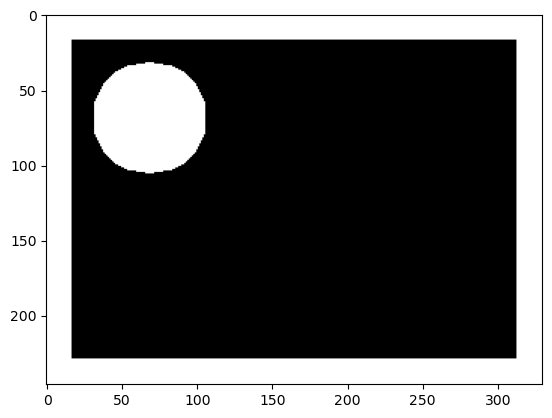

In [8]:
 
dilated_map = np.float32(dilated_map)
plt.imshow(cv2.cvtColor(dilated_map, cv2.COLOR_BGR2RGB))
plt.show()


Vision
======

There are six things to do with the vision : \
_Detect if the camera is obstructed\
_Warp the camera image to only keep the map and make it as if we are exactly on top of it\
_detect the obstacles to create a map\
_detect the goal\
_detect the pose of the thymio, with position and angle\
_show the global path and the kalman filter

Detect the obstruction of the camera
====================================
We convert the image from the camera in grayscale, then in binary, with a tuned threshold so that the intensity required for a pixel to become white is high. We then use the opencv function to count the nonzero values and determine if the camera is obstructed based on an empirically tuned threshold for this count.

Warp the camera Image
=====================

This step converts the camera image to a bird's eye view of the map, where we are right on top of the map, and the map fills the view entirely.
To do this, we detect the 4 crosses in the corners of the map.\
To detect the crosses, we first filter the camera image, then convert it to grayscale, then to binary to get an image where only the crosses are black and the rest is white.\
We then apply match template to this binary image to find all the crosses, using the method 'cv2.TM_CCORR_NORMED', as it is the one that gives the highest correlation score.\
The problem with matchtemplate is that it can find multiple times the same cross. If there is a high correlation between the template and a part of the image at one position, if the template shifts by one pixel on the image, the correlation between the image and the template at this new position will still be very high. This means that matchtemplate alone doesn't give only the positions of the four crosses.\
To get only four positions, we create rectangles at each location where the cross correlation of match template is above a threshold. We then compute the intersection between all of the rectangles and keep the rectangles with the highest cross correlation until no rectangles intersect each other. This guarantees in practice that the four corners are separated.\
We then order the corners, and warp the image thanks to a perspective transform where we force the corners of the map to bbe in the corners of the new image created.

<img src="report/warp_image.png">
<img src="report/bird_image.jpg">

Detect the obstacles
====================

To detect the obstacles, and filter the colors in general, we convert the image to the hsv colorspace. In the hsv colorspace, the colors are represented with the hue, which in opencv is an angle between 0 and 180 degrees. This makes it easier to select the range corresponding to a color in particular.\
In our map, the obstacles are blue, which correspond to a hue angle around 100 degrees. We do a band pass filter where we keep the pixels with an angle close to that of the blue. \
We then keep the value part of the hsv, which corresponds to the grayscale, then apply a binary threshold so that the white part in the binary image are the obstacles.\
Because the thymio is bigger than one pixel, and because we use the A* algorithm to generate the global path, we dilate the obstacles by half the width of the thymio. That way, we can approximate the thymio as one pixel wide.\
We then also create obstacles in the borders to ensure that the thymio doesn't get out of the map.


<img src="report/detect_obstacles.png">
<img src = "report/map_in_polydome2.jpg">

Detect the goal
===============
Just as with the obstacles, I convert the bird's eye view of the map to hsv color and then apply the bandpass filter to only keep the green. I then convert this filtered image to binary to only what was previously green as white, the rest in black. This results to a black picture with a white circle inside.\

I then use the function findContours to find the contours of the circle. This functions applies some sort of edge detection and then links the contours together to create an object. We order all of the contours found by their area, and keep the contour with the biggest area. \
We then convert this contour to a moment. This effectively gets all of the points that are within the area formed by the contour. As each point gets assigned a position and a weight, we can compute the centroid of the contour. If the contour has a big enough area, then the goal position is found, and the position is the centroid of the moment.

<img src="report/detect_goal.png">
<img src = "report/green_filter.jpg">

Detect the thymio
=================
Like before, I use a bandpass filter on the bird's eye view of the map that has been converted to the hsv colorspace, this time to filter the color red.\
On the thymio, there are two circles, one bigger than the other. \
Using findContours, I keep the two biggest circles above an area threshold (to not compute the position of noise) and compute their centroid. \
Using the two positions, I can extract the position of the thymio, which is the center between the centroid, and the angle of the thymio, by using the arctan of the differences in x and y. 

<img src="report/detect_thymio.png">
<img src = "report/red_filter.jpg">

MatchTemplate vs FindContours
=============================

For the detection of the corners of the map, I use the opencv function Matchtemplate. In this case, Matchtemplate works well because the angle of the crosses doesn't change, and it can detect multiple elements in the picture, whilst still being quite robust. Because the corners are black and not white, findcontours would not work in this configuration, and it would be less robust if there is a shade of dark around the map for instance.\
For the goal, I could have used matchtemplate as well, but FindContour proved to be robust and faster, so I chose to use it.\
For the thymio position, I had a problem with matchtemplate when the thymio was too close to the borders, because then the template would be limited by the limits of the image and the given position and angle wouldn't be as precise, whereas FindContours was still robust in those cases.